<a href="https://colab.research.google.com/github/SaeidDaliriSusefi/Lake-Change-Monitoring-Sentinel2/blob/main/Lake_Change_Monitoring_Sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install xee -q


In [6]:
import ee
import xarray as xr
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import rasterio.features
from shapely.geometry import shape
from shapely.ops import unary_union
import geopandas as gpd
import numpy as np
from affine import Affine
import matplotlib.patches as mpatches

In [7]:
ee.Authenticate()
ee.Initialize(project="ee-saeiddalirisu", opt_url='https://earthengine-highvolume.googleapis.com')


In [129]:
# Select the area of intrest
map=geemap.Map(basemap="SATELLITE")
# Add OpenStreetMap
map.add_basemap('OpenStreetMap')
map

In [126]:
roi = map.draw_last_feature.geometry()

start_time = '2016-01-01'
end_time = '2024-12-31'

sentinel = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(roi).filterDate(start_time,end_time).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select((['B3', 'B8']));
def add_year(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    return img.set('year', year)

sentinel_with_year = sentinel.map(add_year)


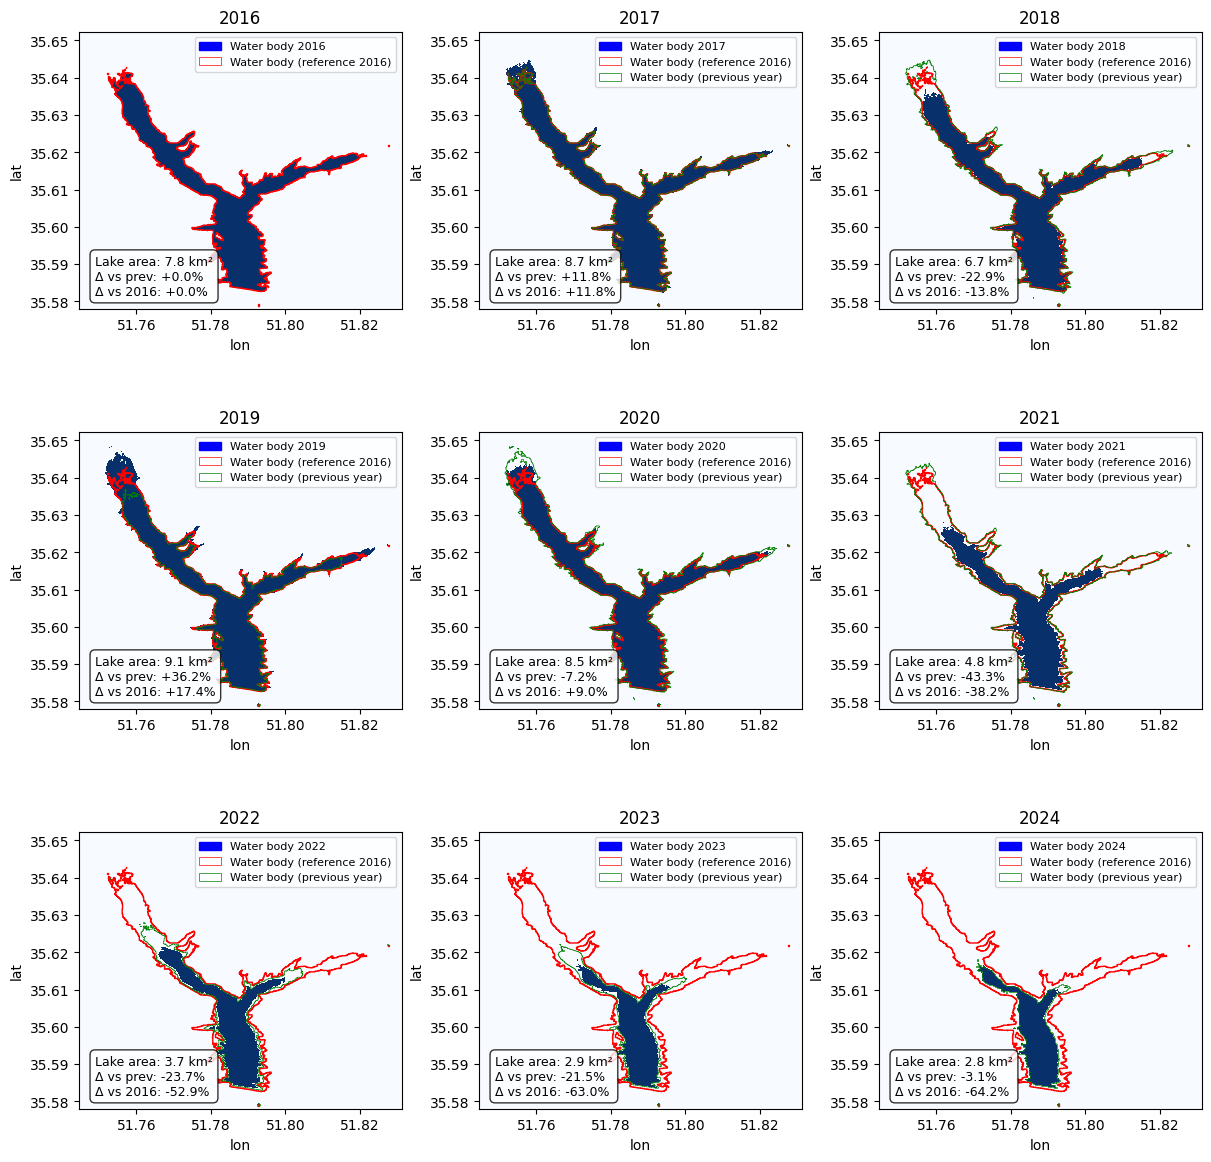

In [129]:
# --- Load and prepare Sentinel NDWI collection ---
years = sentinel_with_year.aggregate_array('year').distinct().sort()

def yearly_mean(year):
    year = ee.Number(year)
    filtered = sentinel_with_year.filter(ee.Filter.eq('year', year))
    mean_image = filtered.mean().set('year', year)
    return mean_image

yearly_means = ee.ImageCollection(years.map(yearly_mean))

def ndwi(img):
    index = img.normalizedDifference(['B3', 'B8']).rename('ndwi')
    return index.copyProperties(img, img.propertyNames())

ndwi_yearly = yearly_means.map(ndwi)

# --- Convert to xarray dataset ---
years = ndwi_yearly.aggregate_array('year').getInfo()
ds = xr.open_dataset(ndwi_yearly, engine='ee', crs='EPSG:4326', scale=0.00009, geometry=roi)

new_time = pd.to_datetime([str(y) for y in years]).year
ds['time'] = new_time
df = ds.to_dataframe().reset_index().dropna(subset=['ndwi'])

# --- Clustering NDWI ---
model = KMeans(n_clusters=2, random_state=42)
df['clustering_raw'] = model.fit_predict(df[['ndwi']])
cluster_means = df.groupby('clustering_raw')['ndwi'].mean()
water_cluster = cluster_means.idxmax()
df['clustering'] = (df['clustering_raw'] == water_cluster).astype(int)

xarr = df.set_index(['time', 'lat', 'lon']).to_xarray()
xarr = xarr.sortby('lon').sortby('lat')

# --- Area and Boundary Calculations ---
lake_pixels_per_year = (xarr.clustering == 1).sum(dim=['lat', 'lon'])
lake_area_km2 = lake_pixels_per_year * 100 / 1_000_000
lake_area_values = lake_area_km2.values

first_year = years[0]
water_mask_first_year = xarr.clustering.sel(time=first_year)
mask_array_uint8 = water_mask_first_year.values.astype(np.uint8)

lon = xarr.lon.values
lat = xarr.lat.values
lon_res = (lon[-1] - lon[0]) / (len(lon) - 1)
lat_res = (lat[-1] - lat[0]) / (len(lat) - 1)
transform = Affine.translation(lon[0] - lon_res / 2, lat[0] - lat_res / 2) * Affine.scale(lon_res, lat_res)

shapes = rasterio.features.shapes(mask_array_uint8, mask=mask_array_uint8 == 1, transform=transform)
polygons = [shape(geom) for geom, value in shapes if value == 1]
waterbody_polygon = unary_union(polygons)
gdf_ref = gpd.GeoDataFrame(geometry=[waterbody_polygon])

# --- Percentage Changes ---
percent_change_prev = [0] + [((lake_area_values[i] - lake_area_values[i - 1]) / lake_area_values[i - 1]) * 100 if lake_area_values[i - 1] != 0 else 0 for i in range(1, len(lake_area_values))]
percent_change_ref = [(val - lake_area_values[0]) / lake_area_values[0] * 100 if lake_area_values[0] != 0 else 0 for val in lake_area_values]

# --- Plotting ---
n_years = len(years)
n_cols = 3
n_rows = (n_years + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

for i, year in enumerate(years):
    data = xarr.clustering.sel(time=year)
    im = data.plot(
        ax=axes[i],
        x='lon',
        y='lat',
        cmap='Blues',
        add_colorbar=False
    )

    year_str = pd.to_datetime(str(year)).year
    area = lake_area_values[i]
    delta_prev = percent_change_prev[i]
    delta_ref = percent_change_ref[i]

    axes[i].set_title(f"{year_str}")
    axes[i].text(
        0.05, 0.05,
        f"Lake area: {area:.1f} km²\n"
        f"Δ vs prev: {delta_prev:+.1f}%\n"
        f"Δ vs {first_year}: {delta_ref:+.1f}%",
        transform=axes[i].transAxes,
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.4')
    )

    # Plot reference boundary (always)
    gdf_ref.boundary.plot(ax=axes[i], edgecolor='red', linewidth=1)

    # Define legend handles dynamically per plot
    handles = []
    # Water body clustering patch (always present)
    handles.append(mpatches.Patch(color='blue', label=f'Water body {year}'))
    # Reference boundary patch (always present)
    handles.append(mpatches.Patch(edgecolor='red', facecolor='none', label=f'Water body (reference {first_year})', linewidth=0.5))

    if i > 0:
        # Plot previous year boundary
        prev_mask = xarr.clustering.sel(time=years[i - 1]).values.astype(np.uint8)
        shapes_prev = rasterio.features.shapes(prev_mask, mask=prev_mask == 1, transform=transform)
        polys_prev = [shape(geom) for geom, val in shapes_prev if val == 1]
        gdf_prev = gpd.GeoDataFrame(geometry=[unary_union(polys_prev)])
        gdf_prev.boundary.plot(ax=axes[i], edgecolor='green', linestyle='-', linewidth=0.5)

        # Add previous year patch only for years > first
        handles.append(mpatches.Patch(edgecolor='green', facecolor='none', label='Water body (previous year)', linestyle='-', linewidth=0.5))

    axes[i].legend(handles=handles, loc='upper right', fontsize=8, framealpha=0.8)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.savefig("lake_area_change_analysis.png", dpi=360, bbox_inches='tight')
plt.show()
